### Example for a function sin(x).

In [1]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Implementation of GPR
def kernel(x0, x1, sigma):
    X0, X1 = np.meshgrid(x0, x1, indexing='ij')
    return np.exp(- sigma * ((X0 - X1) ** 2)) # Gaussian kernel
    #return (np.dot(X0, X1) + 1) ** sigma # Polynomial kernel
    #return np.dot(X0, X1) # Linear kernel

In [3]:
def model_construction(train_x, train_y, initial_sigma):
    beta = float(train_y.var())
    k0 = kernel(train_x, train_x, initial_sigma)
    noise_matrix = np.eye(len(train_x)) * beta
    cn = k0 + noise_matrix
    cn_inv = np.linalg.inv(cn)
    t = train_y.as_matrix()
    t_trans = t.T

    p = - (np.linalg.slogdet(cn)[1] + t_trans.dot(cn_inv).dot(t))
    a = cn_inv.dot(t)
    return (a, p[0])

In [4]:
def gaussian_process_regression(train_x, train_y, initial_sigma, iternum, step): # Perform GPR
    h = 1e-4
    for i in range(0, iternum): # Gradient discent
        v1 = model_construction(train_x, train_y, initial_sigma + h)
        v2 = model_construction(train_x, train_y, initial_sigma - h)
        grad = (v1[1] - v2[1]) / (2 * h)
        initial_sigma -= step * grad
    model = model_construction(train_x, train_y, initial_sigma)
    
    def prediction(x):
        y_new = 0
        for n in range(len(train_x)):
            y_new += kernel(train_x.iloc[n], x, initial_sigma) * model[0][n]
        return y_new
    
    def covariance(x):
        var = 0
        for n in range(len(train_x)):
            var += kernel(train_x.iloc[n], train_x.iloc[n], initial_sigma) * kernel(train_x.iloc[n], train_x.iloc[n], initial_sigma) * model[0][n]
        return np.sqrt(kernel(x, x, initial_sigma) - var)
    return prediction, covariance

In [34]:
#  Make datasets for training
n= 1000
x = np.linspace(0, 2 * np.pi, n)
y = np.array([np.sin(i) for i in x])
y = y + 0.1 * np.random.randn(n)
train_x = pd.DataFrame({'x': x})
train_y = pd.DataFrame({'y': y})

# Perform GPR
prediction, covariance = gaussian_process_regression(train_x, train_y, initial_sigma=50, iternum=1000, step=1)

Text(0,0.5,'y')

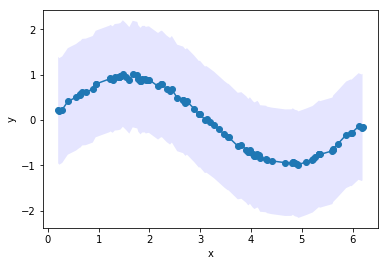

In [35]:
import random
# Make a new dataset
n = 100
test_x = sorted([random.uniform(0, 2 * np.pi) for i in range(0, n)])

# Prediction
test_y = np.array([prediction(i) for i in test_x]).flatten()
test_yerr = np.array([covariance(i) for i in test_x]).flatten()
plt.plot(test_x, test_y, marker='o')
plt.fill_between(test_x, test_y - test_yerr, test_y + test_yerr, facecolor='b', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')